# Channel  Quality Assessment and Pruning

This notebook sketches how to prune bad channels 

In [1]:
import matplotlib.pyplot as p
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

import cedalion
import cedalion.datasets as datasets
import cedalion.nirs
import cedalion.plots as plots
import cedalion.sigproc.quality as quality
import cedalion.xrutils as xrutils
from cedalion import units
np.float_ = np.float64


### Loading raw CW-NIRS data from a SNIRF file and converting it to OD and CONC

This notebook uses a finger-tapping dataset in BIDS layout provided by Rob Luke that is automatically fetched. 
You can also find it [here](https://github.com/rob-luke/BIDS-NIRS-Tapping).

/opt/conda/envs/cedalion/lib/python3.11/site-packages/pint/facets/numpy/numpy_func.py:322: RuntimeWarning: divide by zero encountered in log
  result_magnitude = func(*stripped_args, **stripped_kwargs)


<xarray.DataArray (channel: 567, wavelength: 2, time: 57256)> Size: 519MB
<Quantity([[[           nan 3.12138937e-01 3.12825925e-01 ... 3.15301272e-01
   3.13183262e-01 3.11902644e-01]
  [           nan 4.98693306e-01 4.99938255e-01 ... 4.83065640e-01
   4.77852254e-01 4.74878824e-01]]

 [[           nan 4.49136397e-01 5.94269036e-01 ... 5.41396169e-01
   5.40929120e-01 5.37068593e-01]
  [           nan 4.60251187e-01 8.89825605e-01 ... 9.00275040e-01
   9.00275684e-01 9.00358483e-01]]

 [[           nan 4.12238618e-01 4.14361779e-01 ... 4.33474092e-01
   4.32019376e-01 4.29046075e-01]
  [           nan 4.61148199e-01 5.38319594e-01 ... 5.41729040e-01
   5.38946061e-01 5.33323830e-01]]

 ...

 [[           nan 4.92924148e-02 4.95020525e-02 ... 5.55332569e-02
   5.54290819e-02 5.50452183e-02]
  [           nan 1.39924018e-01 1.40133012e-01 ... 1.53294473e-01
   1.52954134e-01 1.51109889e-01]]

 [[           nan 1.00000000e-06 8.37005534e-05 ... 1.67916187e-04
   1.81179506e-04 1.82338436e-04]
  [           nan 1.00000000e-06 2.99004131e-04 ... 3.64676873e-04
   3.55147887e-04 3.91718590e-04]]

 [[           nan 1.66425287e-01 1.67213360e-01 ... 1.41942360e-01
   1.41813461e-01 1.41390580e-01]
  [           nan 2.70243719e-01 2.71265124e-01 ... 2.21779425e-01
   2.21594769e-01 2.20612124e-01]]], 'dimensionless')>
Coordinates:
  * time        (time) float64 458kB 0.0 0.1112 0.2225 ... 6.37e+03 6.37e+03
    samples     (time) int64 458kB 0 1 2 3 4 5 ... 57251 57252 57253 57254 57255
  * channel     (channel) object 5kB 'S18D18' 'S18D27' ... 'S47D134' 'S5D56'
    source      (channel) object 5kB 'S18' 'S18' 'S18' ... 'S56' 'S47' 'S5'
    detector    (channel) object 5kB 'D18' 'D27' 'D32' ... 'D125' 'D134' 'D56'
  * wavelength  (wavelength) float64 16B 760.0 850.0
Attributes:
    data_type_group:  unprocessed raw

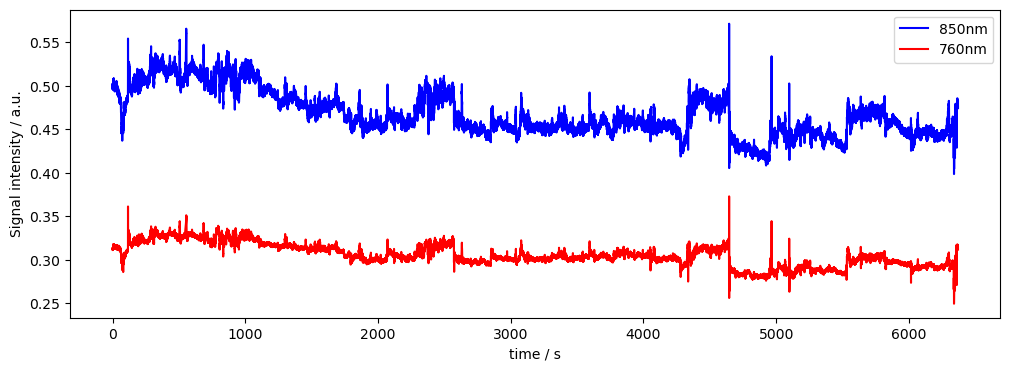

In [2]:
# get example finger tapping dataset

# rec = datasets.get_fingertapping()
snirf_path = "/app/jasmin/data/raw/original/nc726/ninja/nc726.snirf"
recordings = cedalion.io.read_snirf(snirf_path)
rec = recordings[0]
rec["od"] = cedalion.nirs.int2od(rec["amp"])

# Plot some data for visual validation
f,ax = p.subplots(1,1, figsize=(12,4))
ax.plot( rec["amp"].time, rec["amp"].sel(channel="S18D18", wavelength="850"), "b-", label="850nm")
ax.plot( rec["amp"].time, rec["amp"].sel(channel="S18D18", wavelength="760"), "r-", label="760nm")
p.legend()
ax.set_xlabel("time / s")
ax.set_ylabel("Signal intensity / a.u.")

display(rec["amp"])

## Calculating Signal Quality Metrics and applying Masks

To assess channel quality metrics such as SNR, channel distances, average amplitudes, sci, and others, we use small helper functions. 
As input, the quality functions should also expect thresholds for these metrics, so they can feed back both the calculated quality metrics as well as a mask. The masks can then be combined and applied - e.g. to prune channels with low SNR.
The input and output arguments are based on xarray time series, quality parameters / instructions for thresholding. 
The returned mask is a boolean array in the shape and size of the input time series. It indicates where the threshold for our quality metric was passed ("True") and is False otherwise.
Masks can be combined with other masks, for instance to apply several metrics to assess or prune channels. At any point in time, the mask can be applied using the "apply_mask()" function available from cedalion's the xrutils package. 

If you are a user who is mainly interested in high-level application, you can skip to the Section "***Channel Pruning using Quality Metrics and the Pruning Function***" below. The "prune_ch()" function provides a higher abstraction layer to simply prune your data, using the same metrics and functions that are demonstrated below. 
 

### Channel Quality Metrics: SNR

In [3]:
# Here we assess channel quality by SNR
snr_thresh = 16 # the SNR (std/mean) of a channel. Set high here for demonstration purposes

# SNR thresholding using the "snr" function of the quality subpackage
snr, snr_mask = quality.snr(rec["amp"], snr_thresh)

# apply mask function. In this example, we want all signals with an SNR below the threshold to be replaced with "nan". 
# We do not want to collapse / combine any dimension of the mask (last argument: "none")
data_masked_snr_1, masked_elements_1 = xrutils.apply_mask(rec["amp"], snr_mask, "nan", "none")

# alternatively, we can "drop" all channels with an SNR below the threshold. Since the SNR of both wavelength might differ
# (pass the threshold for one wavelength, but not for the other), we collapse to the "channel" dimension.
data_masked_snr_2, masked_elements_2 = xrutils.apply_mask(rec["amp"], snr_mask, "drop", "channel")

# show some results
print(f"channels that were masked according to the SNR threshold: {masked_elements_2}")

# print(f"channels that were masked according to the SNR threshold: {masked_elements_1}")

# dropped:
data_masked_snr_2

mask collapsed to channel dimension
channels that were masked according to the SNR threshold: ['S18D29' 'S17D27' 'S8D52' 'S8D7' 'S7D7' 'S7D3' 'S7D40' 'S6D15' 'S6D33'
 'S10D13' 'S10D10' 'S21D22' 'S20D29' 'S20D25' 'S20D56' 'S20D26' 'S5D50'
 'S5D49' 'S4D7' 'S4D3' 'S4D49' 'S4D8' 'S4D4' 'S3D40' 'S3D36' 'S3D2'
 'S3D35' 'S3D37' 'S13D33' 'S13D35' 'S13D34' 'S11D45' 'S24D21' 'S24D19'
 'S23D19' 'S23D28' 'S22D26' 'S22D55' 'S22D28' 'S2D51' 'S2D8' 'S2D53'
 'S2D6' 'S1D4' 'S1D1' 'S1D6' 'S1D39' 'S16D37' 'S16D34' 'S16D39' 'S15D16'
 'S15D9' 'S14D47' 'S14D9' 'S3D33' 'S3D38' 'S3D34' 'S3D39' 'S4D5' 'S4D40'
 'S4D1' 'S4D6' 'S13D15' 'S13D37' 'S13D11' 'S11D48' 'S11D14' 'S11D9'
 'S11D44' 'S11D43' 'S12D41' 'S12D47' 'S9D10' 'S14D11' 'S15D47' 'S15D34'
 'S16D14' 'S16D1' 'S6D40' 'S10D33' 'S1D37' 'S1D8' 'S8D5' 'S8D54' 'S2D55'
 'S5D7' 'S5D8' 'S5D53' 'S17D29' 'S22D30' 'S20D27' 'S20D54' 'S20D55'
 'S20D28' 'S18D20' 'S23D30' 'S23D21' 'S21D18' 'S21D29' 'S21D30' 'S21D19'
 'S21D24' 'S18D25' 'S20D17' 'S23D26' 'S23D31' 'S24D22'

<xarray.DataArray (channel: 258, wavelength: 2, time: 57256)> Size: 236MB
<Quantity([[[           nan 3.12138937e-01 3.12825925e-01 ... 3.15301272e-01
   3.13183262e-01 3.11902644e-01]
  [           nan 4.98693306e-01 4.99938255e-01 ... 4.83065640e-01
   4.77852254e-01 4.74878824e-01]]

 [[           nan 4.49136397e-01 5.94269036e-01 ... 5.41396169e-01
   5.40929120e-01 5.37068593e-01]
  [           nan 4.60251187e-01 8.89825605e-01 ... 9.00275040e-01
   9.00275684e-01 9.00358483e-01]]

 [[           nan 4.12238618e-01 4.14361779e-01 ... 4.33474092e-01
   4.32019376e-01 4.29046075e-01]
  [           nan 4.61148199e-01 5.38319594e-01 ... 5.41729040e-01
   5.38946061e-01 5.33323830e-01]]

 ...

 [[           nan 2.93724557e-04 1.03234975e-03 ... 1.17116390e-03
   1.17592839e-03 1.16627063e-03]
  [           nan 1.71817921e-03 2.22591964e-03 ... 2.34619090e-03
   2.34297165e-03 2.30755987e-03]]

 [[           nan 1.12416282e-04 5.85775104e-04 ... 7.53304981e-04
   7.54721452e-04 7.57683164e-04]
  [           nan 7.78543917e-04 1.18301074e-03 ... 1.34989677e-03
   1.35685036e-03 1.33830746e-03]]

 [[           nan 4.92924148e-02 4.95020525e-02 ... 5.55332569e-02
   5.54290819e-02 5.50452183e-02]
  [           nan 1.39924018e-01 1.40133012e-01 ... 1.53294473e-01
   1.52954134e-01 1.51109889e-01]]], 'dimensionless')>
Coordinates:
  * time        (time) float64 458kB 0.0 0.1112 0.2225 ... 6.37e+03 6.37e+03
    samples     (time) int64 458kB 0 1 2 3 4 5 ... 57251 57252 57253 57254 57255
  * channel     (channel) object 2kB 'S18D18' 'S18D27' ... 'S31D132' 'S56D125'
    source      (channel) object 2kB 'S18' 'S18' 'S18' ... 'S31' 'S31' 'S56'
    detector    (channel) object 2kB 'D18' 'D27' 'D32' ... 'D128' 'D132' 'D125'
  * wavelength  (wavelength) float64 16B 760.0 850.0
Attributes:
    data_type_group:  unprocessed raw

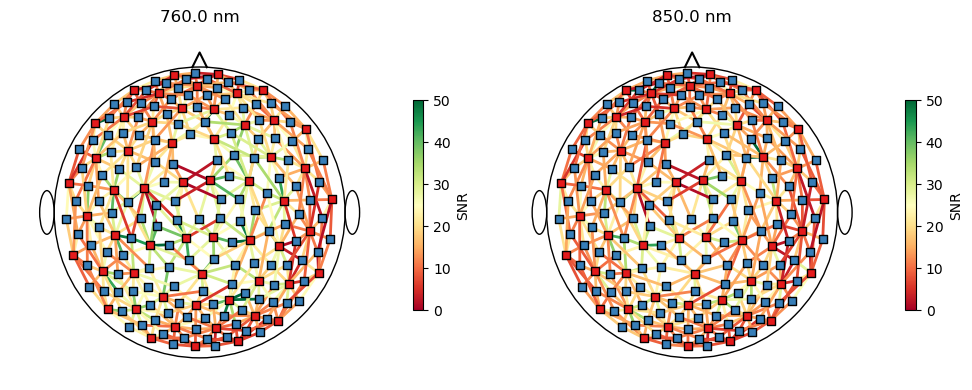

In [4]:
# we can plot the values per channel in a 2D montage
wl_idx = 0
# plots._simple_scalp_plot(rec['amp'], rec.geo3d, snr.isel(wavelength=wl_idx), ax, cmap=p.cm.jet, vmin=0, vmax=25, title='SNR ' + str(rec.wavelengths[wl_idx]))
# plots.scalp_plot(rec, snr.isel(wavelength=wl_idx).values, ax, colormap=p.cm.jet, vmin=0, vmax=25, title='SNR ' + str(rec.wavelengths[wl_idx]))

f, ax = p.subplots(1, 2, figsize=(10, 4))
for i, wl in enumerate(rec["amp"].wavelength.values):
    plots.scalp_plot(
        rec["amp"],
        rec.geo3d,
        snr.sel(wavelength=wl),
        ax[i],
        cmap="RdYlGn",
        vmin=0,
        vmax=50,
        title=f"{wl} nm",
        cb_label="SNR",
        channel_lw=2
    )
f.tight_layout()

### Channel Quality Metrics: Scalp Coupling Index

In [5]:
# Here we can assess the scalp coupling index (SCI) of the channels
sci_threshold = 0.75
window_length = 5*units.s
sci, sci_mask = quality.sci(rec["amp"], window_length, sci_threshold)

/opt/conda/envs/cedalion/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/envs/cedalion/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [6]:
# # we can plot a heat map to visualize the SCI across all time windows and channels
# colors = ["black", "#DC3220", "#5D3A9B", "#0C7BDC"]
# nodes = [0.0, 0.75, 0.751, 1.0]
# sci_cmap = LinearSegmentedColormap.from_list("sci_cmap", list(zip(nodes,colors)))
# sci_binary_cmap = LinearSegmentedColormap.from_list("sci_binary_cmap", list(zip([0,0.5,0.5,1],["#DC3220","#DC3220","#0C7BDC","#0C7BDC"])))

# # plot the heatmap
# f,ax = p.subplots(1,1,figsize=(17,8))

# m = ax.pcolormesh(sci.time, np.arange(len(sci.channel)), sci, shading="nearest", cmap=sci_cmap)
# cb = p.colorbar(m, ax=ax)
# cb.set_label("SCI")
# ax.set_xlabel("time / s")
# p.tight_layout()
# ax.yaxis.set_ticks(np.arange(len(sci.channel)))
# ax.yaxis.set_ticklabels(sci.channel.values);

# # plot the binary heatmap
# f,ax = p.subplots(1,1,figsize=(17,8))

# m = ax.pcolormesh(sci.time, np.arange(len(sci.channel)), sci>0.75, shading="nearest", cmap=sci_binary_cmap)
# cb = p.colorbar(m, ax=ax)
# p.tight_layout()
# ax.yaxis.set_ticks(np.arange(len(sci.channel)))
# ax.yaxis.set_ticklabels(sci.channel.values);
# cb.set_label("SCI > 0.75")
# ax.set_xlabel("time / s");


/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:302: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


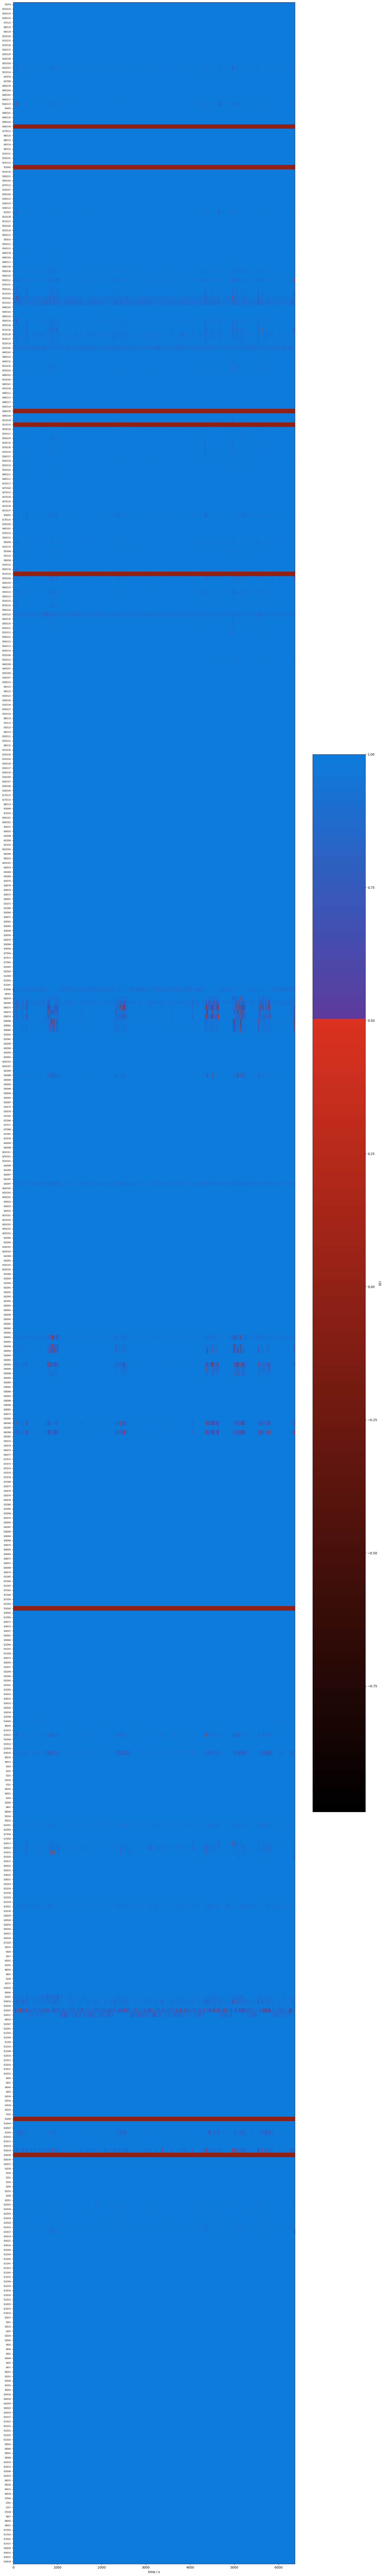

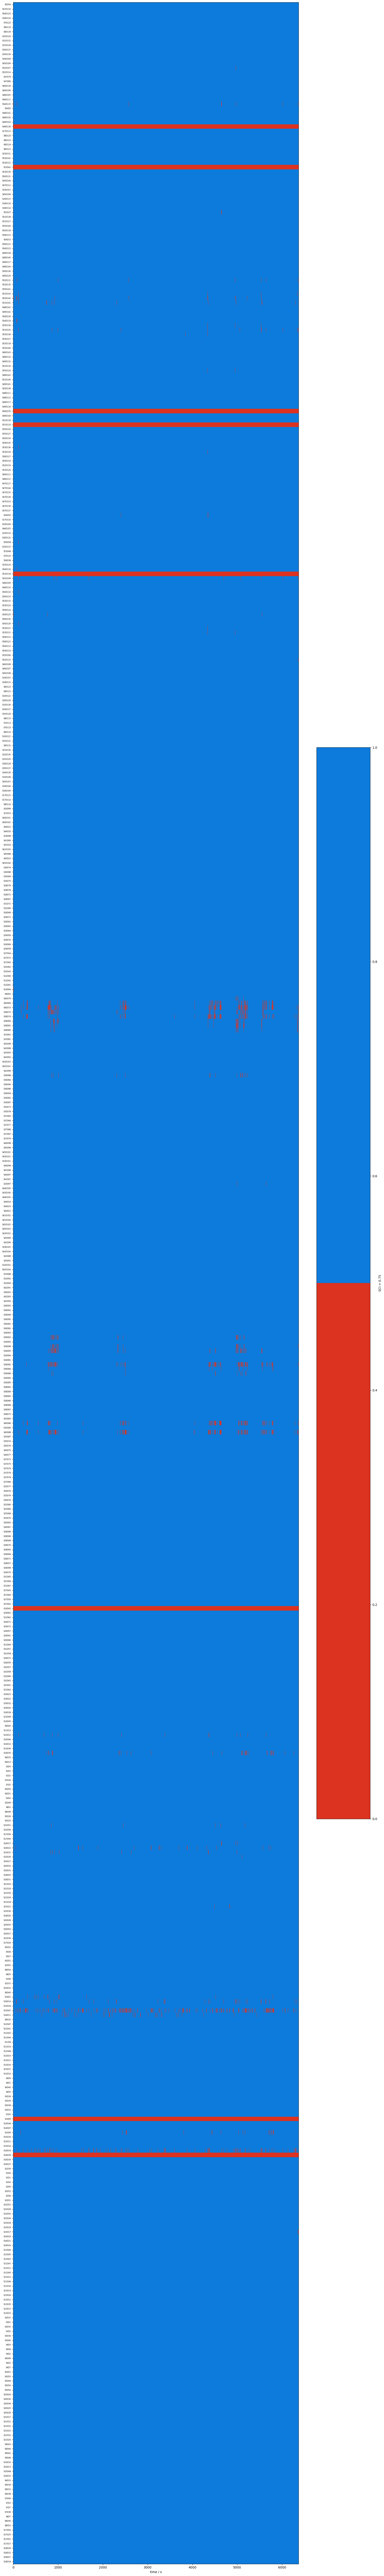

In [7]:
colors = ["black", "#DC3220", "#5D3A9B", "#0C7BDC"]
nodes  = [0.0, 0.75, 0.751, 1.0]
sci_cmap = LinearSegmentedColormap.from_list(
    "sci_cmap", list(zip(nodes, colors))
)
binary_nodes = [0, 0.5, 0.5, 1]
binary_colors= ["#DC3220", "#DC3220", "#0C7BDC", "#0C7BDC"]
sci_binary_cmap = LinearSegmentedColormap.from_list(
    "sci_binary_cmap", list(zip(binary_nodes, binary_colors))
)

# determine figure height so each channel gets ~0.2" of vertical space
n_ch       = len(sci.channel)
inch_per_ch= 0.2
fig_h      = max(8, n_ch * inch_per_ch)

# 1) continuous SCI heatmap
f, ax = p.subplots(1, 1, figsize=(17, fig_h))
m = ax.pcolormesh(
    sci.time,
    np.arange(n_ch),
    sci,
    shading="nearest",
    cmap=sci_cmap
)
cb = p.colorbar(m, ax=ax)
cb.set_label("SCI")

ax.set_xlabel("time / s")
ax.set_yticks(np.arange(n_ch))
ax.set_yticklabels(sci.channel.values, fontsize=6)

# leave plenty of room for the labels
p.subplots_adjust(left=0.35)
p.tight_layout()


# 2) binary SCI > 0.75 heatmap
f, ax = p.subplots(1, 1, figsize=(17, fig_h))
m = ax.pcolormesh(
    sci.time,
    np.arange(n_ch),
    (sci > 0.75).astype(int),
    shading="nearest",
    cmap=sci_binary_cmap
)
cb = p.colorbar(m, ax=ax)
cb.set_label("SCI > 0.75")

ax.set_xlabel("time / s")
ax.set_yticks(np.arange(n_ch))
ax.set_yticklabels(sci.channel.values, fontsize=6)

p.subplots_adjust(left=0.35)
p.tight_layout()

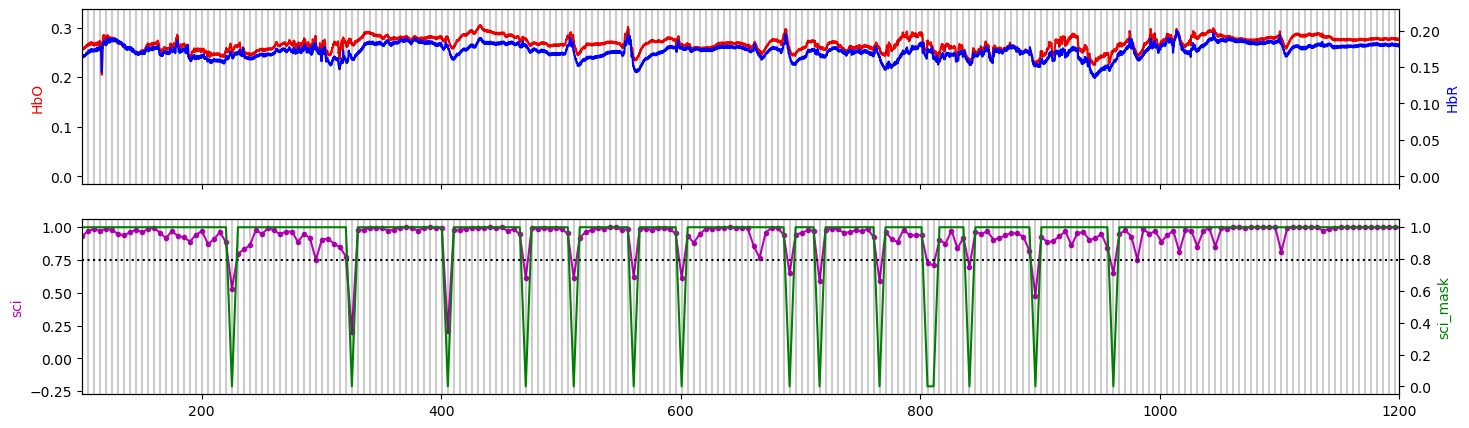

In [8]:
ch = "S16D16"
t1,t2 = 100, 1200
f,ax = p.subplots(2,1, figsize=(17,5), sharex=True)
ax[0].plot(rec["amp"].time, rec["amp"].sel(channel=ch, wavelength=760), "r-")
ax[0].set_ylabel("HbO", color="r")
ax02 = ax[0].twinx()
ax02.plot(rec["amp"].time, rec["amp"].sel(channel=ch, wavelength=850), "b-")
ax02.set_ylabel("HbR", color="b")
ax[1].plot(sci.time, sci.sel(channel=ch), "m.-")
ax[1].set_ylabel("sci", color="m")
ax12 = ax[1].twinx()
ax12.plot(sci_mask.time, sci_mask.sel(channel=ch), "g-")
ax12.set_ylabel("sci_mask", color="g")
ax[1].set_xlim(t1, t2)
ax[1].axhline(0.75, c="k", ls=":")
for i in sci.time.values:
    if i < t1 or i > t2:
        continue
    ax[0].axvline(i, c="k", alpha=.2)
    ax[1].axvline(i, c="k", alpha=.2)

### Channel Quality Metrics: Peak Spectral Power

In [9]:
# We can also look at the peak spectral power which takes the peak power of the cross-correlation signal between the cardiac band of the two wavelengths
psp_threshold = 0.1
psp, psp_mask = quality.psp(rec["amp"], window_length, psp_threshold)

/opt/conda/envs/cedalion/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [10]:
# # We can look at similar heatmaps across time and channels
# # plot the heatmap
# colors = ["black", "#DC3220", "#5D3A9B", "#0C7BDC"]
# nodes = [0.0, 0.45, 0.46, 1.0]
# psp_cmap = LinearSegmentedColormap.from_list("psp_cmap", list(zip(nodes,colors)))
# psp_binary_cmap = LinearSegmentedColormap.from_list("psp_binary_cmap", list(zip([0,0.5,0.5,1],["#DC3220","#DC3220","#0C7BDC","#0C7BDC"])))

# f,ax = p.subplots(1,1,figsize=(17,8))

# m = ax.pcolormesh(psp.time, np.arange(len(psp.channel)), psp, shading="nearest", cmap=psp_cmap)
# cb = p.colorbar(m, ax=ax)
# cb.set_label("PSP")
# ax.set_xlabel("time / s")
# p.tight_layout()
# ax.yaxis.set_ticks(np.arange(len(psp.channel)))
# ax.yaxis.set_ticklabels(psp.channel.values);

# # plot the binary heatmap
# f,ax = p.subplots(1,1,figsize=(17,8))

# m = ax.pcolormesh(psp.time, np.arange(len(psp.channel)), psp>psp_threshold, shading="nearest", cmap=psp_binary_cmap)
# cb = p.colorbar(m, ax=ax)
# p.tight_layout()
# ax.yaxis.set_ticks(np.arange(len(psp.channel)))
# ax.yaxis.set_ticklabels(psp.channel.values);
# cb.set_label("PSP > 0.1")
# ax.set_xlabel("time / s");

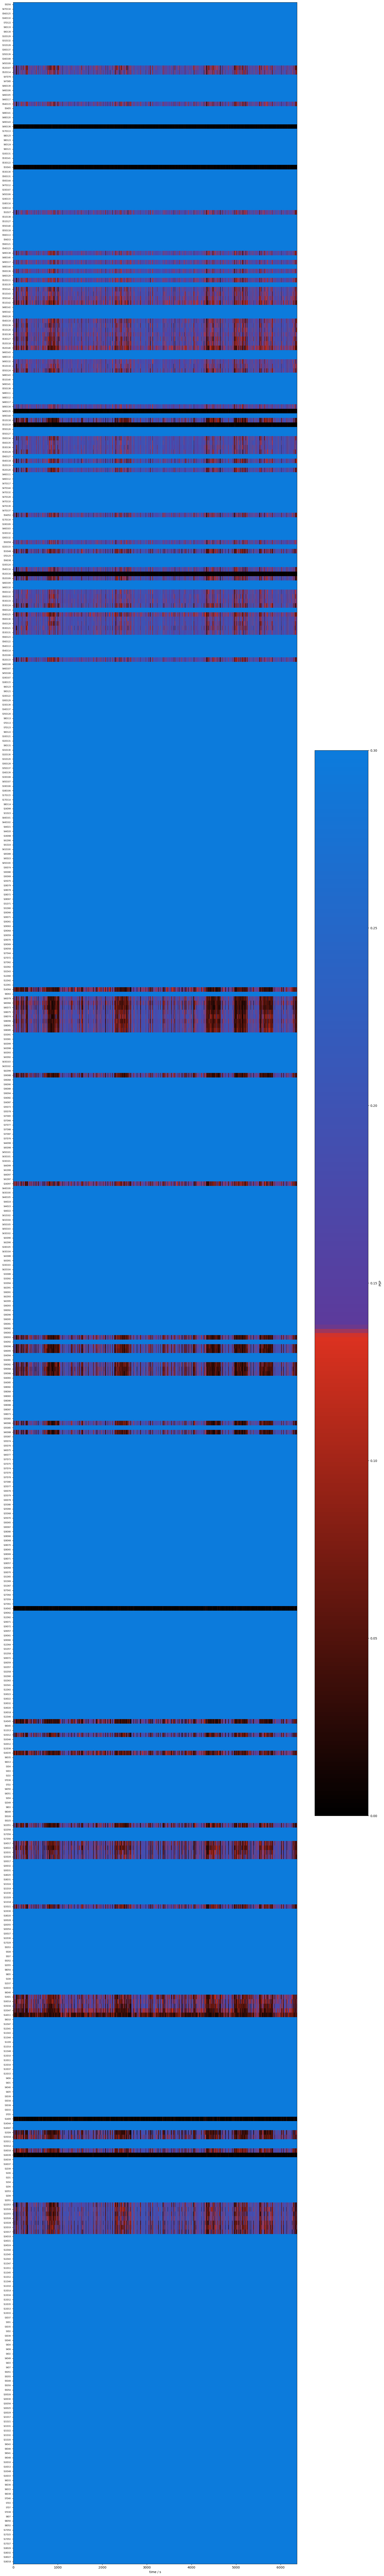

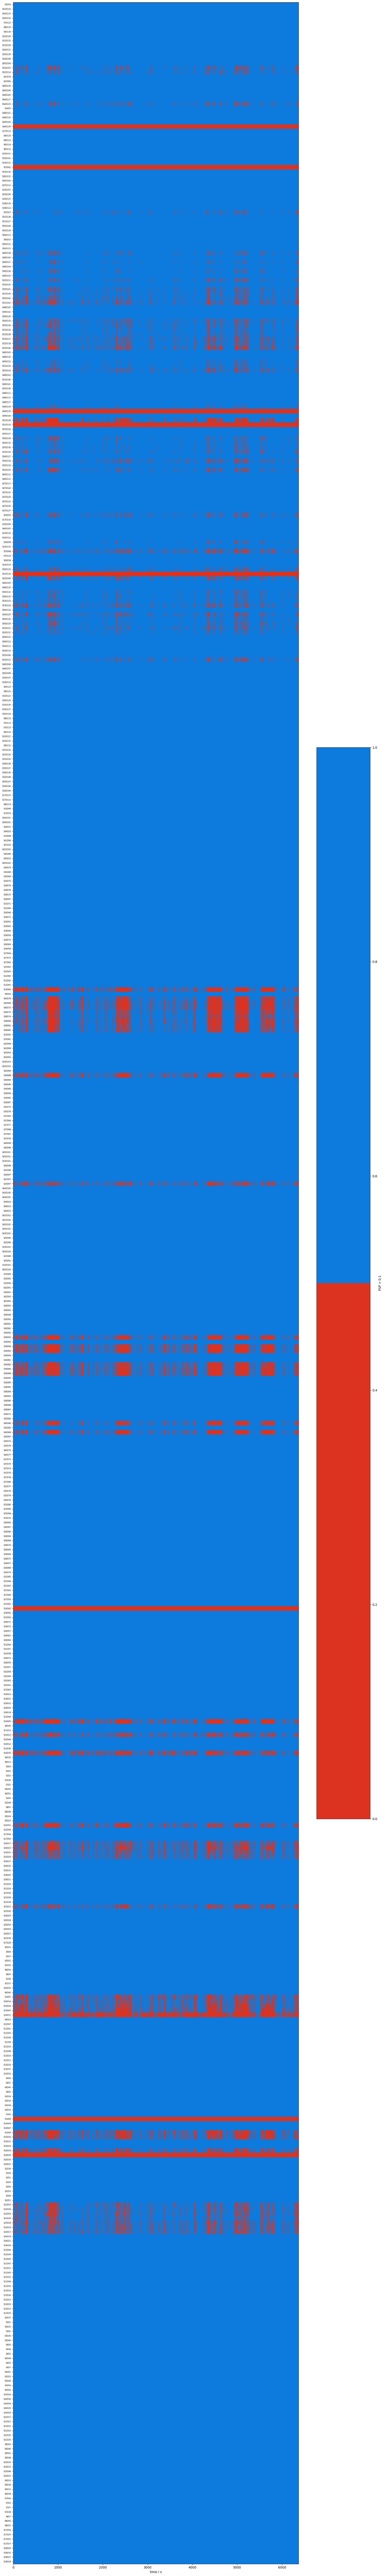

In [11]:
colors = ["black", "#DC3220", "#5D3A9B", "#0C7BDC"]
nodes  = [0.0, 0.45, 0.46, 1.0]
psp_cmap = LinearSegmentedColormap.from_list("psp_cmap", list(zip(nodes, colors)))

bin_nodes = [0, 0.5, 0.5, 1]
bin_cols  = ["#DC3220", "#DC3220", "#0C7BDC", "#0C7BDC"]
psp_binary_cmap = LinearSegmentedColormap.from_list(
    "psp_binary_cmap", list(zip(bin_nodes, bin_cols))
)

# --- determine figure height so each channel gets ~0.2" of space ---
n_ch           = len(psp.channel)
inch_per_chan  = 0.2
fig_height     = max(8, n_ch * inch_per_chan)

# 1) continuous PSP heatmap
fig, ax = p.subplots(figsize=(17, fig_height))
mesh = ax.pcolormesh(
    psp.time,
    np.arange(n_ch),
    psp,
    shading="nearest",
    cmap=psp_cmap,
    vmin=0.0,
    vmax=0.3
)
cb = p.colorbar(mesh, ax=ax)
cb.set_label("PSP")

ax.set_xlabel("time / s")
ax.set_yticks(np.arange(n_ch))
ax.set_yticklabels(psp.channel.values, fontsize=6)

# leave room for the labels
p.subplots_adjust(left=0.35)
p.tight_layout()


# 2) binary PSP > threshold heatmap
fig, ax = p.subplots(figsize=(17, fig_height))
mesh = ax.pcolormesh(
    psp.time,
    np.arange(n_ch),
    (psp > psp_threshold).astype(int),
    shading="nearest",
    cmap=psp_binary_cmap
)
cb = p.colorbar(mesh, ax=ax)
cb.set_label(f"PSP > {psp_threshold}")

ax.set_xlabel("time / s")
ax.set_yticks(np.arange(n_ch))
ax.set_yticklabels(psp.channel.values, fontsize=6)

p.subplots_adjust(left=0.35)
p.tight_layout()

### Combining SCI and PSP
We want both SCI and PSP to be above their respective thresholds for a window to be considered clean. We can then look at the percentage of time both metrics are above the thresholds.

In [18]:
# sci_x_psp_mask = sci_mask & psp_mask
# perc_time_clean = sci_x_psp_mask.sum(dim="time") / len(sci.time)

# # plot the percentage of clean time per channel
# f,ax = p.subplots(1,1,figsize=(8,8))
# # plots.scalp_plot(rec, perc_time_clean, ax, colormap=p.cm.jet, vmin=0, vmax=1, title='Percentage of clean time')
# # plots._simple_scalp_plot(rec['amp'], rec.geo3d, perc_time_clean, ax, cmap=p.cm.jet, vmin=0, vmax=1, title='Percentage of clean time')

# plots.scalp_plot(
#     rec["amp"],
#     rec.geo3d,
#     perc_time_clean,
#     ax,
#     cmap="RdYlGn",
#     vmin=0,
#     vmax=1,
#     title=None,
#     cb_label="Percentage of clean time",
#     channel_lw=2
# )
# f.tight_layout()

# # we can also plot this as a binary heatmap
# f,ax = p.subplots(1,1,figsize=(17,8))

# m = ax.pcolormesh(sci_x_psp_mask.time, np.arange(len(sci_x_psp_mask.channel)), sci_x_psp_mask, shading="nearest", cmap=sci_binary_cmap)
# cb = p.colorbar(m, ax=ax)
# p.tight_layout()
# ax.yaxis.set_ticks(np.arange(len(sci_x_psp_mask.channel)))
# ax.yaxis.set_ticklabels(sci_x_psp_mask.channel.values);
# cb.set_label("PSP > 0.1 and SCI > 0.75")
# ax.set_xlabel("time / s");

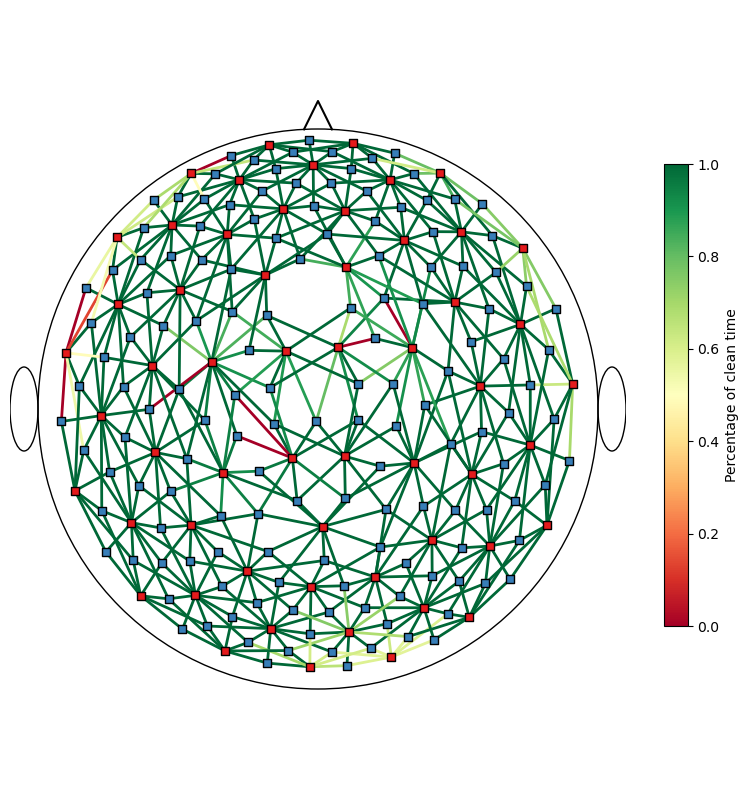

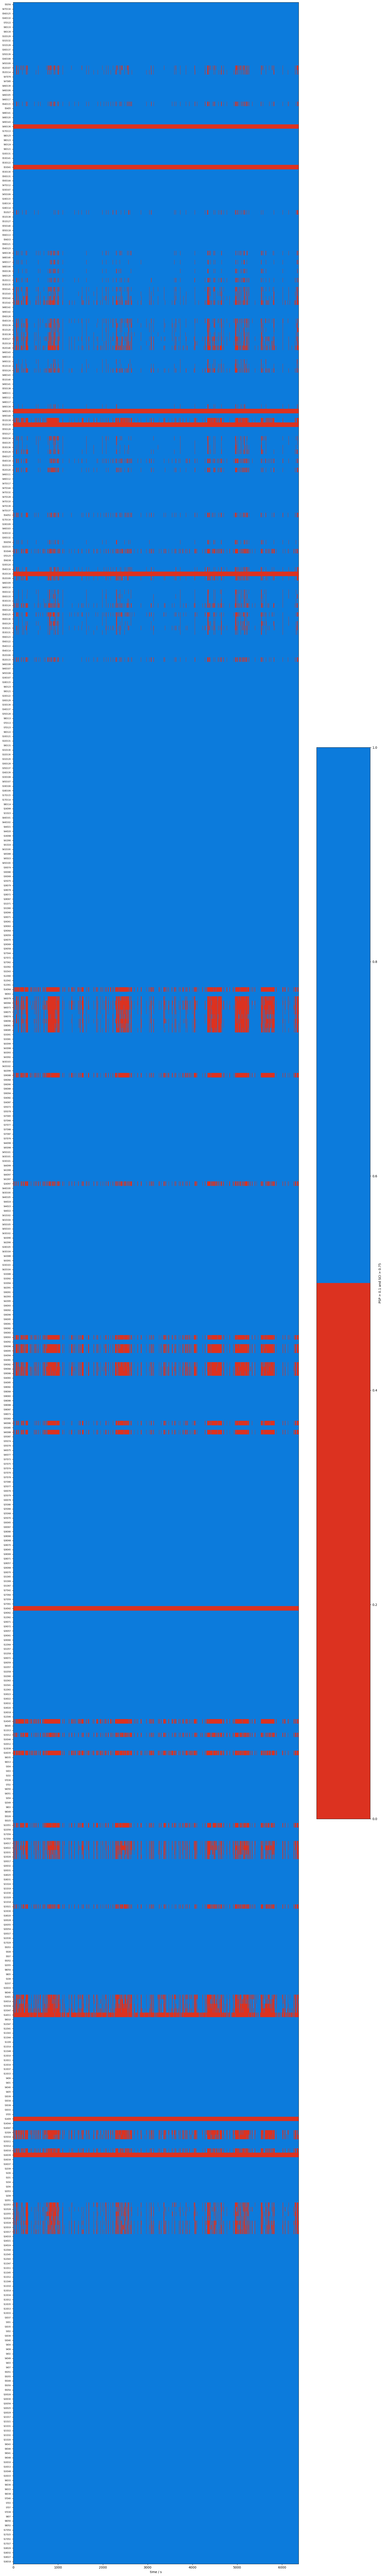

In [13]:
sci_x_psp_mask = sci_mask & psp_mask
perc_time_clean = sci_x_psp_mask.sum(dim="time") / len(sci.time)

# plot the percentage of clean time per channel
f,ax = p.subplots(1,1,figsize=(8,8))
# plots.scalp_plot(rec, perc_time_clean, ax, colormap=p.cm.jet, vmin=0, vmax=1, title='Percentage of clean time')
# plots._simple_scalp_plot(rec['amp'], rec.geo3d, perc_time_clean, ax, cmap=p.cm.jet, vmin=0, vmax=1, title='Percentage of clean time')

plots.scalp_plot(
    rec["amp"],
    rec.geo3d,
    perc_time_clean,
    ax,
    cmap="RdYlGn",
    vmin=0,
    vmax=1,
    title=None,
    cb_label="Percentage of clean time",
    channel_lw=2
)
f.tight_layout()

# binary heatmap of SCI>0.75 & PSP>0.1 with all channel labels shown
n_ch         = len(sci_x_psp_mask.channel)
inch_per_ch  = 0.2                          # vertical inches per channel
fig_height   = max(8, n_ch * inch_per_ch)   # ensure at least 8"

f, ax = p.subplots(1, 1, figsize=(17, fig_height))
m = ax.pcolormesh(
    sci_x_psp_mask.time,
    np.arange(n_ch),
    sci_x_psp_mask,
    shading="nearest",
    cmap=sci_binary_cmap,
    edgecolors=None,
    linewidths=0
)
cb = p.colorbar(m, ax=ax)
cb.set_label("PSP > 0.1 and SCI > 0.75")

ax.set_xlabel("time / s")
ax.set_yticks(np.arange(n_ch))
ax.set_yticklabels(sci_x_psp_mask.channel.values, fontsize=6)

# give extra room on the left for long labels
p.subplots_adjust(left=0.35)
p.tight_layout()

### Channel Quality Metrics: Channel Distance

In [14]:
# Here we assess channel distances. We might want to exclude very short or very long channels
sd_threshs = [1, 4.5]*units.cm # defines the lower and upper bounds for the source-detector separation that we would like to keep

# Source Detector Separation thresholding
ch_dist, sd_mask = quality.sd_dist(rec["amp"], rec.geo3d, sd_threshs)
# print the channel distances
print(f"channel distances are: {ch_dist}")

# apply mask function. In this example, we want to "drop" all channels that do not fall inside sd_threshs 
# i.e. drop channels shorter than 1cm and longer than 4.5cm. We want to collapse along the "channel" dimension.
data_masked_sd, masked_elements = xrutils.apply_mask(rec["amp"], sd_mask, "drop", "channel")

# display the resultings
print(f"channels that were masked according to the SD Distance thresholds: {masked_elements}")
data_masked_sd

channel distances are: <xarray.DataArray (channel: 567)> Size: 5kB
<Quantity([16.095 16.865 18.924 18.994 16.47  16.431 19.    19.855 15.818 19.849
 20.544 15.95  31.306 19.859 19.059 15.494 16.895 18.945 18.797 15.857
 15.811 19.649 19.236 15.896 16.395 19.283 19.01  19.032 18.694 19.91
 19.594 19.119 19.04  18.209 17.635 19.797 19.203 19.991 19.486 18.541
 19.882 19.159 20.108 19.07  18.772 19.629 19.579 18.881 19.272 18.919
 18.876 19.526 19.723 18.91  19.462 18.078 18.041 18.714 19.221 19.326
 19.28  18.734 18.836 19.136 18.729 19.114 18.653 18.421 18.989 19.159
 18.523 18.523 21.624 18.723 20.62  20.657 19.287 18.627 21.265 21.567
 18.72  18.716 19.978 21.391 19.631 18.875 19.764 19.186 18.896 19.429
 20.285 20.493 19.003 18.798 20.16  20.436 18.755 18.694 20.648 15.883
 32.139 33.737 34.054 32.358 33.864 32.958 33.861 33.43  32.677 34.058
 32.492 33.502 32.066 33.328 33.528 32.118 32.749 32.172 32.824 33.592
 30.78  34.173 33.766 33.885 34.329 34.178 30.207 31.213 33.248 35.186
 

<xarray.DataArray (channel: 567, wavelength: 2, time: 57256)> Size: 519MB
<Quantity([[[           nan 3.12138937e-01 3.12825925e-01 ... 3.15301272e-01
   3.13183262e-01 3.11902644e-01]
  [           nan 4.98693306e-01 4.99938255e-01 ... 4.83065640e-01
   4.77852254e-01 4.74878824e-01]]

 [[           nan 4.49136397e-01 5.94269036e-01 ... 5.41396169e-01
   5.40929120e-01 5.37068593e-01]
  [           nan 4.60251187e-01 8.89825605e-01 ... 9.00275040e-01
   9.00275684e-01 9.00358483e-01]]

 [[           nan 4.12238618e-01 4.14361779e-01 ... 4.33474092e-01
   4.32019376e-01 4.29046075e-01]
  [           nan 4.61148199e-01 5.38319594e-01 ... 5.41729040e-01
   5.38946061e-01 5.33323830e-01]]

 ...

 [[           nan 4.92924148e-02 4.95020525e-02 ... 5.55332569e-02
   5.54290819e-02 5.50452183e-02]
  [           nan 1.39924018e-01 1.40133012e-01 ... 1.53294473e-01
   1.52954134e-01 1.51109889e-01]]

 [[           nan 1.00000000e-06 8.37005534e-05 ... 1.67916187e-04
   1.81179506e-04 1.82338436e-04]
  [           nan 1.00000000e-06 2.99004131e-04 ... 3.64676873e-04
   3.55147887e-04 3.91718590e-04]]

 [[           nan 1.66425287e-01 1.67213360e-01 ... 1.41942360e-01
   1.41813461e-01 1.41390580e-01]
  [           nan 2.70243719e-01 2.71265124e-01 ... 2.21779425e-01
   2.21594769e-01 2.20612124e-01]]], 'dimensionless')>
Coordinates:
  * time        (time) float64 458kB 0.0 0.1112 0.2225 ... 6.37e+03 6.37e+03
    samples     (time) int64 458kB 0 1 2 3 4 5 ... 57251 57252 57253 57254 57255
  * channel     (channel) object 5kB 'S18D18' 'S18D27' ... 'S47D134' 'S5D56'
    source      (channel) object 5kB 'S18' 'S18' 'S18' ... 'S56' 'S47' 'S5'
    detector    (channel) object 5kB 'D18' 'D27' 'D32' ... 'D125' 'D134' 'D56'
  * wavelength  (wavelength) float64 16B 760.0 850.0
Attributes:
    data_type_group:  unprocessed raw

### Channel Quality Metrics: Mean Amplitudes

In [15]:
# Here we assess average channel amplitudes. We might want to exclude very small or large signals
amp_threshs = [0.1, 3]# define whether a channel's amplitude is within a certain range

# Amplitude thresholding
mean_amp, amp_mask = quality.mean_amp(rec["amp"], amp_threshs)

# apply mask function. In this example, we want drop all channels that do not fall inside the amplitude thresholds. 
# We collapse to the "channel" dimension.
data_masked_amp, masked_elements = xrutils.apply_mask(rec["amp"], amp_mask, "drop", "channel")

# display the results
print(f"channels that were masked according to the amplitude threshold: {masked_elements}")
data_masked_amp


mask collapsed to channel dimension
channels that were masked according to the amplitude threshold: ['S7D7' 'S7D3' 'S7D40' 'S20D56' 'S5D50' 'S3D40' 'S13D35' 'S11D46' 'S24D21'
 'S24D19' 'S22D55' 'S15D16' 'S14D9' 'S3D33' 'S3D38' 'S3D34' 'S4D5' 'S4D40'
 'S4D6' 'S13D15' 'S13D37' 'S13D11' 'S13D10' 'S11D9' 'S11D44' 'S11D43'
 'S12D41' 'S12D47' 'S9D10' 'S14D11' 'S15D47' 'S15D34' 'S16D14' 'S16D1'
 'S6D40' 'S10D33' 'S1D37' 'S1D8' 'S8D54' 'S2D55' 'S5D52' 'S5D7' 'S5D8'
 'S5D53' 'S22D30' 'S20D27' 'S20D54' 'S20D28' 'S18D20' 'S23D21' 'S21D18'
 'S21D29' 'S21D30' 'S21D24' 'S18D31' 'S18D25' 'S20D32' 'S20D17' 'S23D26'
 'S23D31' 'S24D17' 'S17D56' 'S22D51' 'S5D25' 'S5D26' 'S8D49' 'S8D3'
 'S4D51' 'S4D50' 'S7D2' 'S7D36' 'S1D2' 'S3D3' 'S3D4' 'S6D13' 'S6D35'
 'S13D36' 'S10D12' 'S10D46' 'S9D45' 'S14D45' 'S12D46' 'S19D32' 'S19D22'
 'S32D41' 'S32D63' 'S32D57' 'S14D42' 'S31D65' 'S28D57' 'S28D65' 'S28D68'
 'S28D80' 'S25D70' 'S25D66' 'S25D80' 'S37D78' 'S37D79' 'S37D73' 'S40D77'
 'S35D74' 'S35D85' 'S40D86' 'S35D83' '

<xarray.DataArray (channel: 239, wavelength: 2, time: 57256)> Size: 219MB
<Quantity([[[       nan 0.31213894 0.31282593 ... 0.31530127 0.31318326 0.31190264]
  [       nan 0.49869331 0.49993825 ... 0.48306564 0.47785225 0.47487882]]

 [[       nan 0.4491364  0.59426904 ... 0.54139617 0.54092912 0.53706859]
  [       nan 0.46025119 0.88982561 ... 0.90027504 0.90027568 0.90035848]]

 [[       nan 0.41223862 0.41436178 ... 0.43347409 0.43201938 0.42904608]
  [       nan 0.4611482  0.53831959 ... 0.54172904 0.53894606 0.53332383]]

 ...

 [[0.09292513 0.0988094  0.09912644 ... 0.10526761 0.10435515 0.10396523]
  [0.12089747 0.12827754 0.1287066  ... 0.13040765 0.12876802 0.12803571]]

 [[       nan 0.11299639 0.11355886 ... 0.11187043 0.11076275 0.11004331]
  [       nan 0.11397311 0.11452772 ... 0.10741936 0.10603946 0.10493152]]

 [[       nan 0.16642529 0.16721336 ... 0.14194236 0.14181346 0.14139058]
  [       nan 0.27024372 0.27126512 ... 0.22177942 0.22159477 0.22061212]]], 'dimensionless')>
Coordinates:
  * time        (time) float64 458kB 0.0 0.1112 0.2225 ... 6.37e+03 6.37e+03
    samples     (time) int64 458kB 0 1 2 3 4 5 ... 57251 57252 57253 57254 57255
  * channel     (channel) object 2kB 'S18D18' 'S18D27' ... 'S45D109' 'S5D56'
    source      (channel) object 2kB 'S18' 'S18' 'S18' ... 'S51' 'S45' 'S5'
    detector    (channel) object 2kB 'D18' 'D27' 'D32' ... 'D120' 'D109' 'D56'
  * wavelength  (wavelength) float64 16B 760.0 850.0
Attributes:
    data_type_group:  unprocessed raw

### Channel Pruning using Quality Metrics and the Pruning Function

To prune channels according to quality criteria, we do not have to manually go through the steps above. Instead, we can create quality masks for the metrics that we are interested in and hand them to a dedicated channel pruning function. The prune function expects a list of quality masks alongside a logical operator that defines how these masks should be combined.

In [16]:
# as above we use three metrics and define thresholds accordingly
snr_thresh = 16 # the SNR (std/mean) of a channel. 
sd_threshs = [1, 4.5]*units.cm # defines the lower and upper bounds for the source-detector separation that we would like to keep
amp_threshs = [0.1, 3] # define whether a channel's amplitude is within a certain range

# then we calculate the masks for each metric: SNR, SD distance and mean amplitude
_, snr_mask = quality.snr(rec["amp"], snr_thresh)
_, sd_mask = quality.sd_dist(rec["amp"], rec.geo3d, sd_threshs)
_, amp_mask = quality.mean_amp(rec["amp"], amp_threshs)
# you can also include other masks, e.g. the SCI mask

# put all masks in a list
masks = [snr_mask, sd_mask, amp_mask]

# prune channels using the masks and the operator "all", which will keep only channels that pass all three metrics
amp_pruned, drop_list = quality.prune_ch(rec["amp"], masks, "all")

# print list of dropped channels
print(f"List of pruned channels: {drop_list}")
# display the new data xarray
amp_pruned

mask collapsed to channel dimension
List of pruned channels: ['S18D29' 'S17D27' 'S8D52' 'S8D7' 'S7D7' 'S7D3' 'S7D40' 'S6D15' 'S6D33'
 'S10D13' 'S10D10' 'S21D22' 'S20D29' 'S20D25' 'S20D56' 'S20D26' 'S5D50'
 'S5D49' 'S4D7' 'S4D3' 'S4D49' 'S4D8' 'S4D4' 'S3D40' 'S3D36' 'S3D2'
 'S3D35' 'S3D37' 'S13D33' 'S13D35' 'S13D34' 'S11D46' 'S11D45' 'S24D21'
 'S24D19' 'S23D19' 'S23D28' 'S22D26' 'S22D55' 'S22D28' 'S2D51' 'S2D8'
 'S2D53' 'S2D6' 'S1D4' 'S1D1' 'S1D6' 'S1D39' 'S16D37' 'S16D34' 'S16D39'
 'S15D16' 'S15D9' 'S14D47' 'S14D9' 'S3D33' 'S3D38' 'S3D34' 'S3D39' 'S4D5'
 'S4D40' 'S4D1' 'S4D6' 'S13D15' 'S13D37' 'S13D11' 'S13D10' 'S11D48'
 'S11D14' 'S11D9' 'S11D44' 'S11D43' 'S12D41' 'S12D47' 'S9D10' 'S14D11'
 'S15D47' 'S15D34' 'S16D14' 'S16D1' 'S6D40' 'S10D33' 'S1D37' 'S1D8' 'S8D5'
 'S8D54' 'S2D55' 'S5D52' 'S5D7' 'S5D8' 'S5D53' 'S17D29' 'S22D30' 'S20D27'
 'S20D54' 'S20D55' 'S20D28' 'S18D20' 'S23D30' 'S23D21' 'S21D18' 'S21D29'
 'S21D30' 'S21D19' 'S21D24' 'S18D31' 'S18D25' 'S20D32' 'S20D17' 'S23D26'
 'S23D

<xarray.DataArray (channel: 138, wavelength: 2, time: 57256)> Size: 126MB
<Quantity([[[           nan 3.12138937e-01 3.12825925e-01 ... 3.15301272e-01
   3.13183262e-01 3.11902644e-01]
  [           nan 4.98693306e-01 4.99938255e-01 ... 4.83065640e-01
   4.77852254e-01 4.74878824e-01]]

 [[           nan 4.49136397e-01 5.94269036e-01 ... 5.41396169e-01
   5.40929120e-01 5.37068593e-01]
  [           nan 4.60251187e-01 8.89825605e-01 ... 9.00275040e-01
   9.00275684e-01 9.00358483e-01]]

 [[           nan 4.12238618e-01 4.14361779e-01 ... 4.33474092e-01
   4.32019376e-01 4.29046075e-01]
  [           nan 4.61148199e-01 5.38319594e-01 ... 5.41729040e-01
   5.38946061e-01 5.33323830e-01]]

 ...

 [[1.00000000e-06 5.05272169e-01 5.06266145e-01 ... 5.08710588e-01
   5.05450902e-01 5.03586054e-01]
  [1.00000000e-06 6.60982111e-01 6.62846058e-01 ... 6.64559473e-01
   6.58374388e-01 6.54607992e-01]]

 [[           nan 1.10557614e-01 1.12879596e-01 ... 1.23005046e-01
   1.22481338e-01 1.19873486e-01]
  [           nan 2.37554661e-01 2.40915432e-01 ... 2.54335850e-01
   2.52689267e-01 2.44624525e-01]]

 [[9.29251270e-02 9.88094047e-02 9.91264366e-02 ... 1.05267611e-01
   1.04355146e-01 1.03965230e-01]
  [1.20897466e-01 1.28277537e-01 1.28706599e-01 ... 1.30407651e-01
   1.28768022e-01 1.28035706e-01]]], 'dimensionless')>
Coordinates:
  * time        (time) float64 458kB 0.0 0.1112 0.2225 ... 6.37e+03 6.37e+03
    samples     (time) int64 458kB 0 1 2 3 4 5 ... 57251 57252 57253 57254 57255
  * channel     (channel) object 1kB 'S18D18' 'S18D27' ... 'S49D141' 'S51D120'
    source      (channel) object 1kB 'S18' 'S18' 'S18' ... 'S50' 'S49' 'S51'
    detector    (channel) object 1kB 'D18' 'D27' 'D32' ... 'D134' 'D141' 'D120'
  * wavelength  (wavelength) float64 16B 760.0 850.0
Attributes:
    data_type_group:  unprocessed raw

### Timeseries Quality Metric: Global Variance of the Temporal Derivative

/opt/conda/envs/cedalion/lib/python3.11/site-packages/pint/facets/numpy/numpy_func.py:322: RuntimeWarning: divide by zero encountered in log
  result_magnitude = func(*stripped_args, **stripped_kwargs)


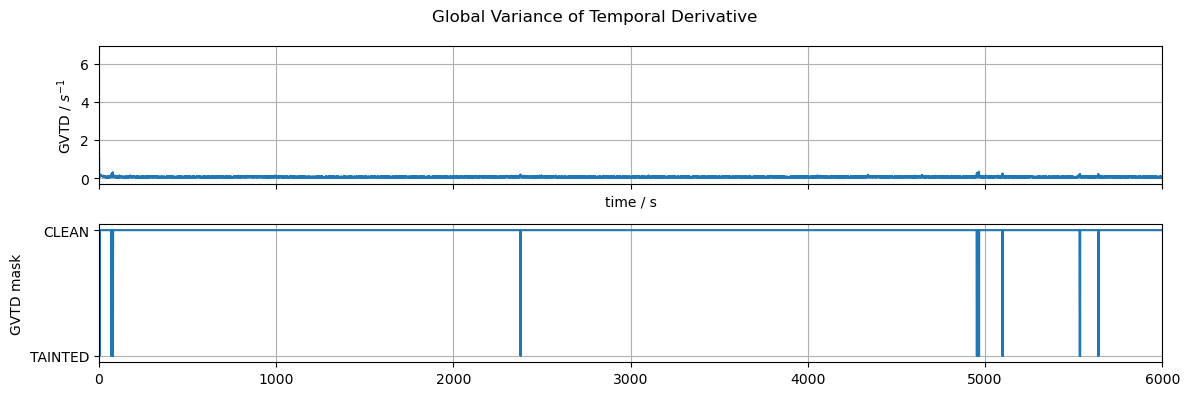

In [17]:
# we can plot the timeseries of the GVTD to evaluate motion in the data
gvtd, gvtd_mask = quality.gvtd(rec["amp"], stat_type="histogram_mode")

f, ax = p.subplots(2,1, figsize=(12,4), sharex=True)
ax[0].plot(gvtd.time, gvtd)
ax[1].plot(gvtd.time, gvtd_mask)
ax[0].set_xlabel("time / s")
ax[0].set_ylabel("GVTD / $s^{-1}$")
ax[1].set_ylabel("GVTD mask")
ax[1].set_yticks([0,1])
ax[1].set_yticklabels(["TAINTED","CLEAN"])
ax[0].set_xlim(0, 6000)
ax[0].grid()
ax[1].grid()
f.suptitle("Global Variance of Temporal Derivative")
p.tight_layout()